# Trabalho 1 - Modelos interpretáveis para a predição de ataques cardíacos

Dataset com 11 parâmetros numéricos e categóricos para prever a ocorrência de um ataque cardíaco.

Gustavo Geyer, Dhruv Babani

In [ ]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


heart_data = pd.read_csv("./heart_failure_clinical_records_dataset.csv")
# Lista de colunas categóricas que devem ser convertidas para booleanas
bool_columns = ['sex', 'diabetes', 'anaemia', 'high_blood_pressure', 'smoking', 'DEATH_EVENT']

# Conversão explícita para booleano
heart_data[bool_columns] = heart_data[bool_columns].astype(bool)
# a coluna "time" não contribui para a predição
heart_data = heart_data.drop(columns="time")

target_name = "DEATH_EVENT" # 1 = morte, 0 = sobrevive
y = heart_data[target_name]

x = heart_data.drop(columns=[target_name])

Aqui, mapeamos colunas binárias em valores booleanos. Para a coluna 'sexo', assumimos um binário de 0 para gênero feminino e 1 para masculino.

In [2]:
x

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
0,75.0,False,582,False,20,True,265000.00,1.9,130,True,False
1,55.0,False,7861,False,38,False,263358.03,1.1,136,True,False
2,65.0,False,146,False,20,False,162000.00,1.3,129,True,True
3,50.0,True,111,False,20,False,210000.00,1.9,137,True,False
4,65.0,True,160,True,20,False,327000.00,2.7,116,False,False
...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,False,61,True,38,True,155000.00,1.1,143,True,True
295,55.0,False,1820,False,38,False,270000.00,1.2,139,False,False
296,45.0,False,2060,True,60,False,742000.00,0.8,138,False,False
297,45.0,False,2413,False,38,False,140000.00,1.4,140,True,True


In [3]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    bool   
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    bool   
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    bool   
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    bool   
 10  smoking                   299 non-null    bool   
dtypes: bool(5), float64(3), int64(3)
memory usage: 15.6 KB


## Seleção Baseada em tipo de dados

Utilizamos o dtype das colunas para separar as variáveis categóricas das numéricas.

In [4]:
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=bool)
categorical_columns_selector = selector(dtype_include=bool)

numerical_columns = numerical_columns_selector(x)
categorical_columns = categorical_columns_selector(x)

In [5]:
numerical_columns

['age',
 'creatinine_phosphokinase',
 'ejection_fraction',
 'platelets',
 'serum_creatinine',
 'serum_sodium']

In [6]:
categorical_columns

['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

## Dispatch de colunas para processos distintos

Como as colunas categóricas são binárias, não precisamos usar one-hot encoding, pois já realizamos o pré-processamento por manualmente associando booleans a essas colunas. Utilizamos apenas um Scaler padrão para normalizar as variáveis numéricas

In [7]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

#categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

Depois passamos para o ColumnTransformer

In [8]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('standard-scaler', numerical_preprocessor, numerical_columns)])

Aqui vamos diretamente associar os modelos a pipelines para normalização.

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

knn = make_pipeline(preprocessor, KNeighborsClassifier())
naive = make_pipeline(preprocessor, GaussianNB())
tree = make_pipeline(preprocessor, DecisionTreeClassifier(random_state=42))

modelos = {
    "KNN": knn,
    "Naive Bayes": naive,
    "Decision Tree": tree
}


Gráfico da pipeline

In [10]:
from sklearn import set_config
set_config(display='diagram')
knn
naive
tree

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standard-scaler',
                                                  StandardScaler(),
                                                  ['age',
                                                   'creatinine_phosphokinase',
                                                   'ejection_fraction',
                                                   'platelets',
                                                   'serum_creatinine',
                                                   'serum_sodium'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

Utilizamos o método Stratified K-fold do sklearn para ter uma visão geral de diferentes estimativas de modelos por validação cruzada. Vamos, então, aprofundar a validação em cada modelo.

In [11]:
# Validação cruzada k-fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("\nResultados com validação cruzada (5-fold):")

for nome, modelo in modelos.items():
    scores = cross_val_score(modelo, x, y, cv=cv, scoring='accuracy')
    print(f"\nModelo: {nome}")
    print(f"Acurácia média: {scores.mean():.4f}")
    print(f"Desvio padrão: {scores.std():.4f}")


Resultados com validação cruzada (5-fold):

Modelo: KNN
Acurácia média: 0.7458
Desvio padrão: 0.0554

Modelo: Naive Bayes
Acurácia média: 0.7190
Desvio padrão: 0.0428

Modelo: Decision Tree
Acurácia média: 0.6457
Desvio padrão: 0.0497


Divisão 80/20 do dataset para treino e teste

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)

### Árvore de Decisão

Accuracy: 0.7333333333333333
F1: 0.717978848413631
Precision: 0.728937728937729
Recall: 0.7142857142857143


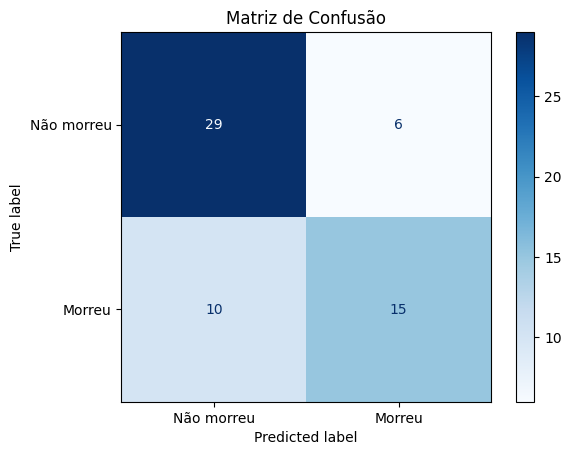

[Text(0.6097261235955056, 0.9666666666666667, 'standard-scaler__serum_creatinine <= 0.431\ngini = 0.418\nsamples = 239\nvalue = [168, 71]\nclass = Vivo'),
 Text(0.35428370786516855, 0.9, 'standard-scaler__ejection_fraction <= -0.496\ngini = 0.331\nsamples = 201\nvalue = [159, 42]\nclass = Vivo'),
 Text(0.4820049157303371, 0.9333333333333333, 'True  '),
 Text(0.11797752808988764, 0.8333333333333334, 'standard-scaler__serum_creatinine <= -0.44\ngini = 0.491\nsamples = 53\nvalue = [30, 23]\nclass = Vivo'),
 Text(0.0449438202247191, 0.7666666666666667, 'standard-scaler__age <= 0.037\ngini = 0.165\nsamples = 11\nvalue = [10, 1]\nclass = Vivo'),
 Text(0.02247191011235955, 0.7, 'gini = 0.0\nsamples = 10\nvalue = [10, 0]\nclass = Vivo'),
 Text(0.06741573033707865, 0.7, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = Morto'),
 Text(0.19101123595505617, 0.7666666666666667, 'standard-scaler__creatinine_phosphokinase <= -0.417\ngini = 0.499\nsamples = 42\nvalue = [20, 22]\nclass = Morto'),
 Text

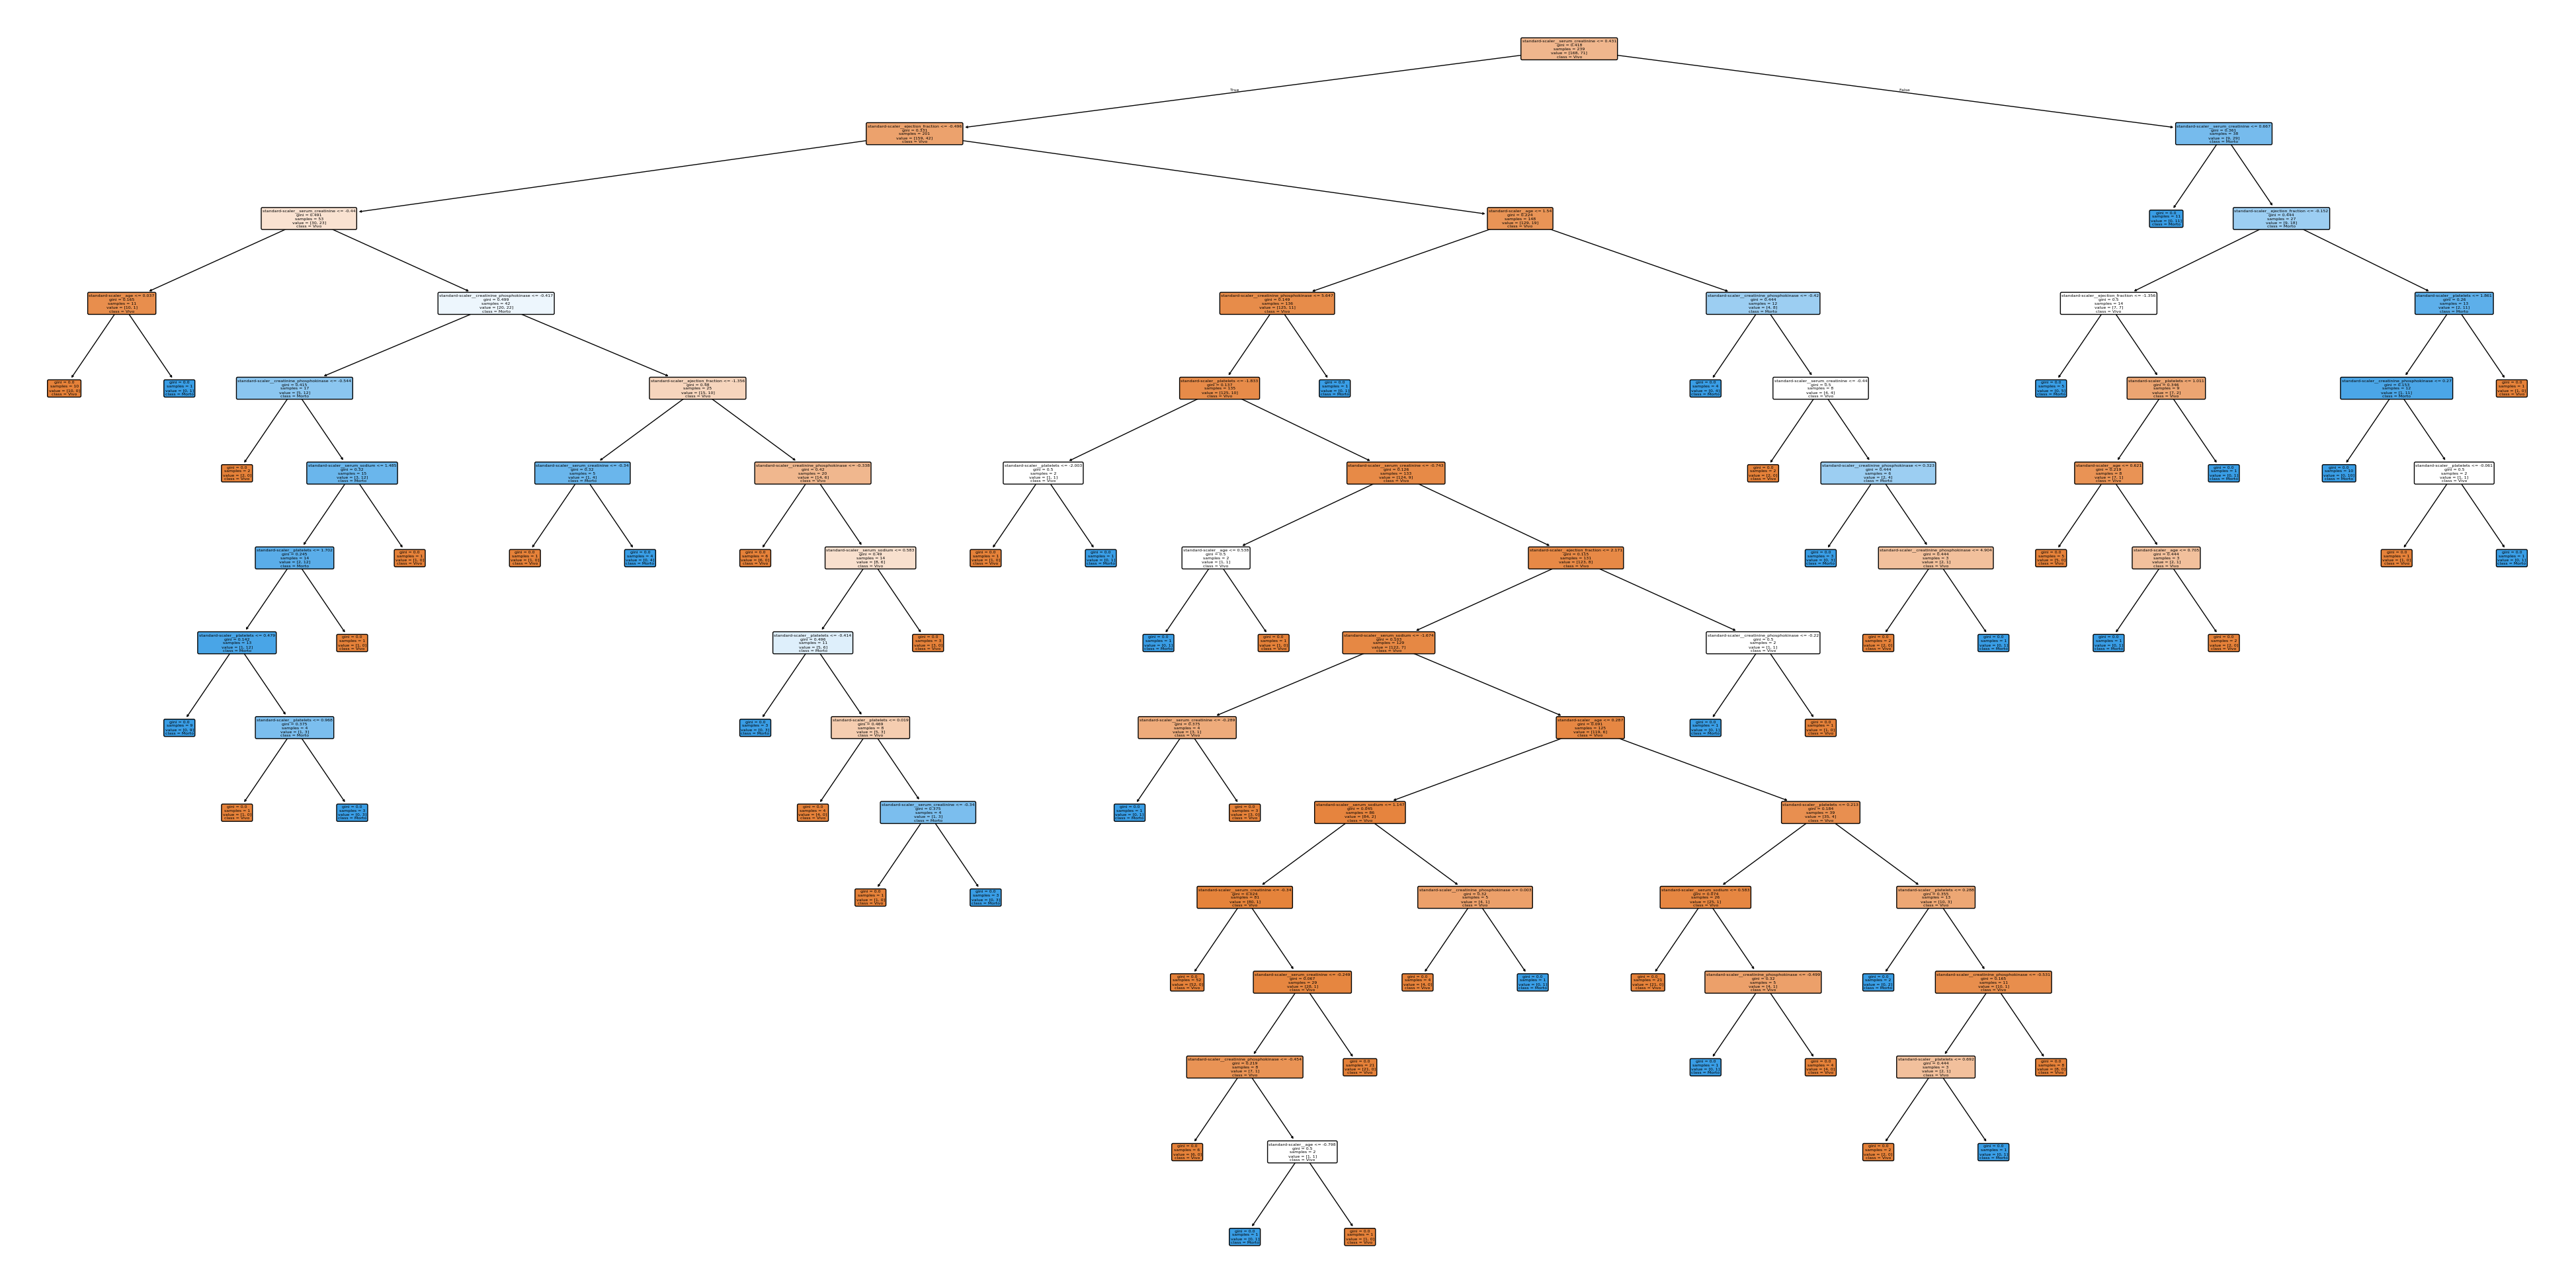

In [13]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

tree.fit(x_train, y_train)
y_pred = tree.predict(x_test)
acc = tree.score(x_test, y_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1:', f1_score(y_test, y_pred, average='macro'))
print('Precision:', precision_score(y_test, y_pred, average='macro'))
print('Recall:', recall_score(y_test, y_pred, average='macro'))


cm = confusion_matrix(y_test, y_pred, labels=[False, True])
ConfusionMatrixDisplay(cm, display_labels=["Não morreu", "Morreu"]).plot(cmap=plt.cm.Blues)
plt.title(f"Matriz de Confusão")
plt.show()

from sklearn.tree import plot_tree
tree_model = tree.named_steps['decisiontreeclassifier']

plt.figure(figsize=(50,25))

plot_tree(tree_model,
          feature_names=tree.named_steps['columntransformer'].get_feature_names_out(),
          class_names=["Vivo", "Morto"],
          filled=True,
          rounded=True)


Aqui não definimos um tamanho máximo de profundidade de árvore, portanto o modelo gerou uma árvore de profundidade 14 com resultados satisfatórios de classificação. Nâo se espera uma árvore desse tamanho para um dataset com esse número de features, mas vamos estudar os outros modelos para poder entender o que está acontecendo.

### KNN
Para o KNN, começamos utilizando o GridSearch para validação cruzada, em que passamos uma range de possíveis hiperparâmetros para o KNN. Escolhemos validar o tamanho de k, tipo de peso (uniforme ou por distância) e tipo de distância: Euclidiana ou Minkowski.

In [14]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_neighbors': range(3,30),
    'weights': ['uniform', 'distance'],
    'p': [1,2] # 1 para Minkowski, 2 para dist. euclidiana (de acordo com a documentação). Vale testar os dois.
}

knn_grid = GridSearchCV(KNeighborsClassifier(), params, n_jobs=-1, scoring='recall')
knn_grid.fit(x_train, y_train)

print(f"Melhores parâmetros: {knn_grid.best_params_}")
print(f"Melhor CV: {knn_grid.best_score_}")

Melhores parâmetros: {'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Melhor CV: 0.28095238095238095


Aqui tentamos diferentes a métricas alvo (manualmente). No fim, mirar para recall nos deu a melhor estimativa no geral mesmo com um score geral baixo. Então, instanciamos um novo modelo com k = 3 e distância Minkowski, utilizando o scaler. O CV sugere que peso uniforme é a melhor escolha, mas o peso por distância trouxe métricas similares no entanto ligeiramente melhores. No entanto, concluímos que isso se dá pela diferença entre a porção de treino e de teste real (predict(x_test)), então ambos pesos tem resultados similares.

In [15]:
#best_knn  = knn_grid.best_estimator_
best_knn = make_pipeline(preprocessor, KNeighborsClassifier(n_neighbors=3, p=1, weights='distance'))
best_knn.fit(x_train, y_train)
y_hat = best_knn.predict(x_test)

print("Acurácia: ", accuracy_score(y_test, y_hat))
print("F1: ", f1_score(y_test, y_hat, average='macro'))
print("Precisão: ", precision_score(y_test, y_hat, average='macro'))
print("Recall: ", recall_score(y_test, y_hat, average='macro'))

Acurácia:  0.7166666666666667
F1:  0.6571428571428571
Precisão:  0.79
Recall:  0.6657142857142857


Plotamos, então, a matriz de confusão desse estimador para entender a discrepância entre as diferentes métricas e avaliar onde o modelo "mais erra"

              precision    recall  f1-score   support

       False       0.68      0.97      0.80        35
        True       0.90      0.36      0.51        25

    accuracy                           0.72        60
   macro avg       0.79      0.67      0.66        60
weighted avg       0.77      0.72      0.68        60



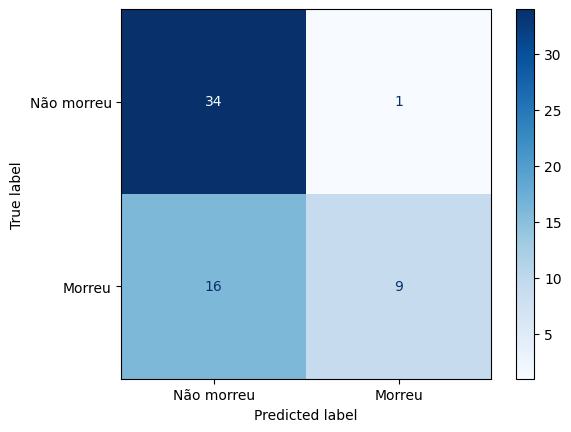

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_hat, labels=best_knn.classes_)
display_confusion_matrix = ConfusionMatrixDisplay(cm,  display_labels=["Não morreu", "Morreu"])
display_confusion_matrix.plot(cmap=plt.cm.Blues)
print(classification_report(y_test, y_hat))

### Vemos que o estimador tem uma certa tendência a dar falsos negativos e poucos positivos reais, ou seja, é um tanto conservador em dar casos de morte.
Seu score geral é puxado para cima com mais acertos de negativos reais (não morreu), mas entende-se que isso não é bom o suficiente - um estimador "otimista" demais para predições críticas como essa em cenários reais pode ter grandes impactos

C:\Users\gusta\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PermutationExplainer explainer: 61it [00:18,  2.45it/s]                        


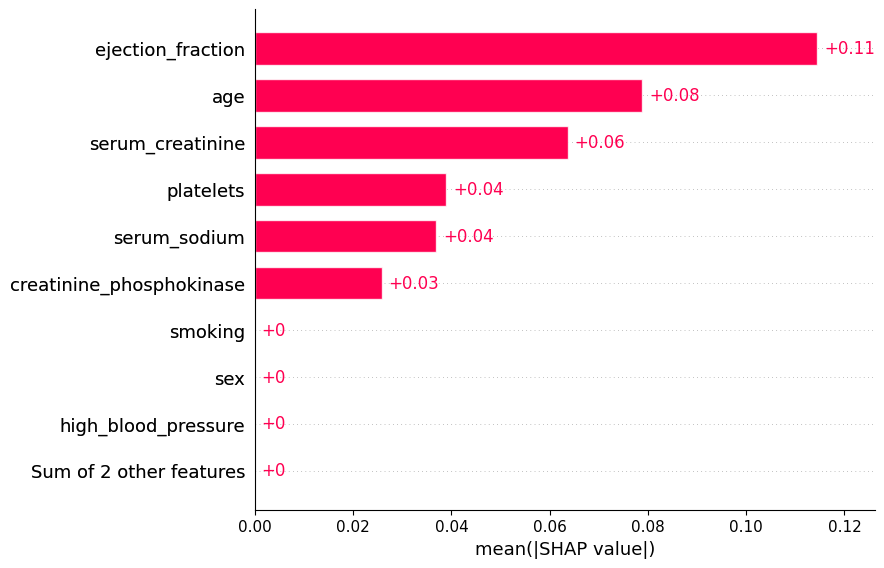

In [19]:
import shap

def predict_fn(x):
    return best_knn.predict_proba(x)[:, 1]


explainer = shap.Explainer(predict_fn, x_train.astype(float))
shap_values = explainer(x_test.astype(float).iloc[0:1000, :])
shap.plots.bar(shap_values)

#### Utilizando o explicador SHAP, podemos ver que pelo menos cinco features tem um impacto nulo na predição, ou seja, apenas seis são realmente utilizadas.
Isso provavelmente está introduzindo um gargalo na complexidade do modelo, pois estamos reduzindo drasticamente quantas variáveis temos para classificação. O mesmo gargalo é observado nos outros estimadores.

# Naïve Bayes
Vamos tentar usar o método multinomial também para comparação. Aqui, usamos um preprocessador com o MinMax scaler para o NB multinomial, pois o Standard scaler acaba produzindo alguns valores negativos, o que não é compatível com o modelo multinomial.

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

preprocessor_minmax = ColumnTransformer([
    ('minmax-scaler', MinMaxScaler(), numerical_columns)
])

gnb_params = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

mnnb_params = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 5.0],
    'fit_prior': [True, False]
}

mnnb_grid = GridSearchCV(MultinomialNB(), mnnb_params, cv=cv, scoring='accuracy')
gnb_grid = GridSearchCV(GaussianNB(), gnb_params, cv=cv, scoring='accuracy')
gnb_grid.fit(x_train, y_train)
mnnb_grid.fit(x_train, y_train)

print("Melhores parâmetros Gaussiano:", gnb_grid.best_params_)
print("Melhor score CV Gaussiano:", gnb_grid.best_score_)

print("Melhores parâmetros MN:", mnnb_grid.best_params_)
print("Melhor score CV MN:", mnnb_grid.best_score_)

Melhores parâmetros Gaussiano: {'var_smoothing': 1e-09}
Melhor score CV Gaussiano: 0.7195035460992909
Melhores parâmetros MN: {'alpha': 0.01, 'fit_prior': True}
Melhor score CV MN: 0.5023936170212766


Vamos testar da mesma forma que fizemos para o KNN, testando com os parâmetros de melhor score estipulados na validação cruzada de grid search.

In [ ]:

best_gnb = make_pipeline(preprocessor, GaussianNB(var_smoothing=1e-09))
best_gnb.fit(x_train, y_train)
y_hat_g = best_gnb.predict(x_test)

print("Gaussiano")

print("Acurácia: ", accuracy_score(y_test, y_hat_g))
print("F1: ", f1_score(y_test, y_hat_g, average='macro'))
print("Precisão: ", precision_score(y_test, y_hat_g, average='macro'))
print("Recall: ", recall_score(y_test, y_hat_g, average='macro'))

print("_____________\n")
print("Multinomial")
best_mnnb = make_pipeline(preprocessor_minmax, MultinomialNB(alpha=0.01, fit_prior=True))
best_mnnb.fit(x_train, y_train)
y_hat_mn = best_mnnb.predict(x_test)


print("Acurácia: ", accuracy_score(y_test, y_hat_mn))
print("F1: ", f1_score(y_test, y_hat_mn, average='macro'))
print("Precisão: ", precision_score(y_test, y_hat_mn, average='macro'))
print("Recall: ", recall_score(y_test, y_hat_mn, average='macro'))


Gaussiano
Acurácia:  0.6166666666666667
F1:  0.5193312434691745
Precisão:  0.6201923076923077
Recall:  0.5571428571428572
_____________

Multinomial
Acurácia:  0.5833333333333334
F1:  0.3684210526315789
Precisão:  0.2916666666666667
Recall:  0.5


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print(f"Melhor score Gaussiano: {best_gnb.score(x_test,y_test)}")
print(f"Melhor score Multinomial: {best_mnnb.score(x_test, y_test)}")

Melhor score Gaussiano: 0.6166666666666667
Melhor score Multinomial: 0.5833333333333334


Ao que indica, o modelo Gaussiano obtem resultados de teste um pouco melhores. Normalmente, o modelo multinomial é melhor quando temos muitas variáveis binárias, mas no nosso caso, essas variáveis não contribuem para a predição da condição final; assim o método Gaussiano pode estar obtendo mais desempenho em cima das variáveis numéricas.

Gaussiano
              precision    recall  f1-score   support

       False       0.62      0.91      0.74        35
        True       0.62      0.20      0.30        25

    accuracy                           0.62        60
   macro avg       0.62      0.56      0.52        60
weighted avg       0.62      0.62      0.56        60

____________________________________________________________

Multinomial
              precision    recall  f1-score   support

       False       0.58      1.00      0.74        35
        True       0.00      0.00      0.00        25

    accuracy                           0.58        60
   macro avg       0.29      0.50      0.37        60
weighted avg       0.34      0.58      0.43        60



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


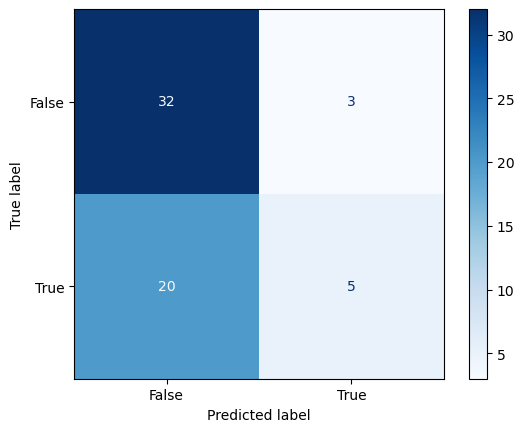

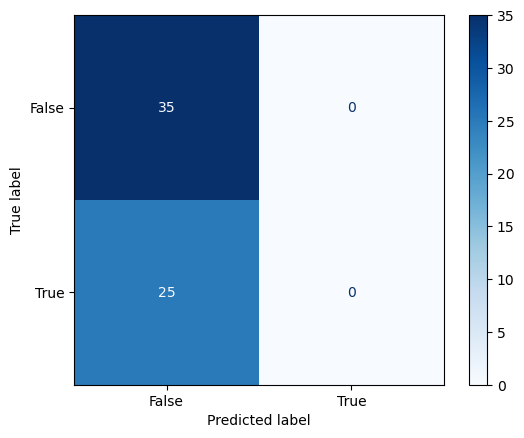

In [ ]:
print("Gaussiano")
cm = confusion_matrix(y_test, y_hat_g, labels=best_gnb.classes_)
display_confusion_matrix = ConfusionMatrixDisplay(cm, display_labels=best_gnb.classes_)
display_confusion_matrix.plot(cmap=plt.cm.Blues)
print(classification_report(y_test, y_hat_g))
print("____________________________________________________________\n")

print("Multinomial")
cm = confusion_matrix(y_test, y_hat_mn, labels=best_mnnb.classes_)
display_confusion_matrix = ConfusionMatrixDisplay(cm, display_labels=best_mnnb.classes_)
display_confusion_matrix.plot(cmap=plt.cm.Blues)
print(classification_report(y_test, y_hat_mn))

Com a matriz de confusão, é evidente que o mesmo vício de falsos negativos é presente e ainda mais acentuado no Naïve Bayes. No caso do multinomial, há um caso extremo de underfitting em que o modelo não estimou nenhum caso positivo, tendo assim uma taxa de recall 1:0. 

Apesar da acurácia ser significativa, sabemos que o modelo não é nada útil para a predição que queremos fazer.

## Conclusão

Observados os dados e limitações dos modelos e possivelmente até do dataset, concluímos que para este problema, a árvore de decisão é a melhor escolha entre os 3 modelos. Ainda é possível aprofundar mais no treinamento do modelo e aplicar mais etapas de validação cruzada e técnicas de poda para encontrar um modelo de árvore que tenha um desempenho melhor ainda.